<a href="https://colab.research.google.com/github/Bpriya42/DeepLearning/blob/main/Data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped

FOLDERNAME = 'ColabNotebooks/682_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
!pip3 install datasets

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [ ]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/FairFace", "0.25")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


In [ ]:
ds_split = ds['train'].train_test_split(test_size=0.2, seed=42)

In [ ]:
from collections import Counter

# race_counts_train = Counter(ds['train']['race'])
race_counts_train = Counter(ds['train']['race'])
print(race_counts_train)

min_race_count = min(race_counts_train.values())
print(f'Minimum samples per race: {min_race_count}')

Counter({3: 16527, 5: 13367, 1: 12319, 0: 12287, 2: 12233, 6: 10795, 4: 9216})
Minimum samples per race: 9216


In [ ]:
from datasets import DatasetDict, Dataset
import pandas as pd

# Assuming `dataset` is your DatasetDict and 'train' is the split you want to balance
# Convert the DatasetDict to pandas DataFrame
df_train = ds['train'].to_pandas()
df_val = ds['validation'].to_pandas()


In [ ]:
# Step 1: Find the minimum count among all races
min_count_train = df_train['race'].value_counts().min()
min_count_val = df_val['race'].value_counts().min()

# Step 2: Randomly sample data for each race
balanced_df_train = df_train.groupby('race').apply(lambda x: x.sample(min_count_train, random_state=42)).reset_index(drop=True)
balanced_df_val = df_val.groupby('race').apply(lambda x: x.sample(min_count_val, random_state=42)).reset_index(drop=True)

<ipython-input-11-fbbdd0190ddb>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df_train = df_train.groupby('race').apply(lambda x: x.sample(min_count_train, random_state=42)).reset_index(drop=True)
<ipython-input-11-fbbdd0190ddb>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df_val = df_val.groupby('race').apply(lambda x: x.sample(min_count_val, random_state=42)).reset_index(drop=True

In [ ]:
balanced_df_train

,image,age,gender,race,service_test
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,0,True
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0,True
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,0,True
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0,False
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0,False
...,...,...,...,...,...
64507,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,1,6,True
64508,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,0,6,False
64509,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,6,True
64510,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,0,6,False


In [ ]:
balanced_df_train = balanced_df_train.iloc[:, 0:4]

In [ ]:
balanced_df_train

,image,age,gender,race
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0
...,...,...,...,...
64507,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,1,6
64508,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,0,6
64509,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,6
64510,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,0,6


In [ ]:
balanced_df_val = balanced_df_val.iloc[:, 0:4]
balanced_df_val

,image,age,gender,race
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,1,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,0
...,...,...,...,...
8458,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,6
8459,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,6
8460,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,0,6
8461,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,6


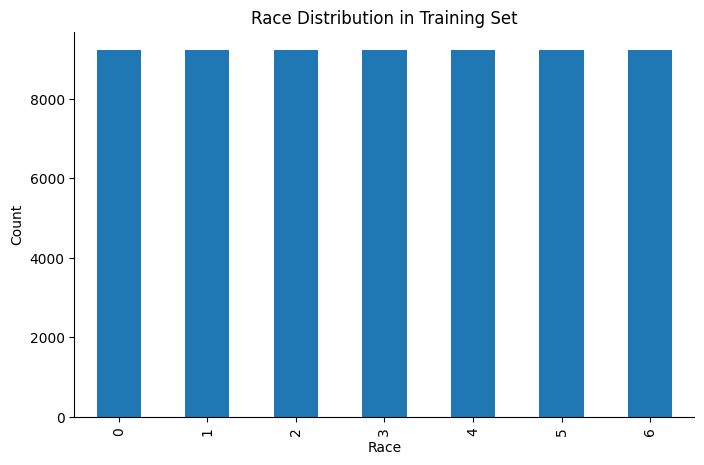

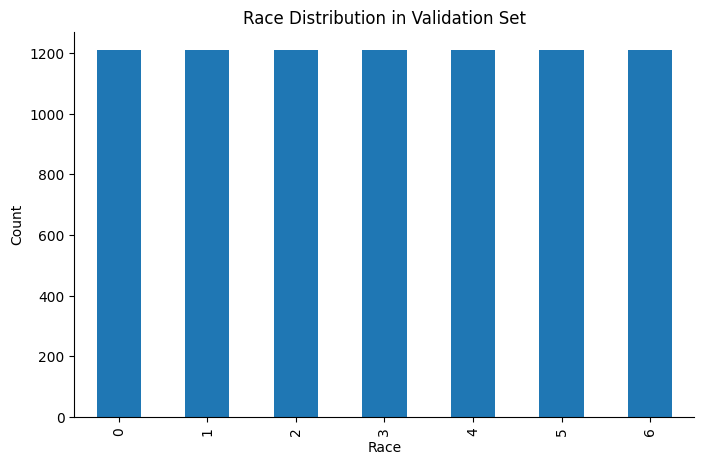

In [ ]:
# Plot for training set
plt.figure(figsize=(8, 5))
balanced_df_train['race'].value_counts().plot(kind='bar', title='Race Distribution in Training Set')
plt.xlabel('Race')
plt.ylabel('Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Plot for validation set
plt.figure(figsize=(8, 5))
balanced_df_val['race'].value_counts().plot(kind='bar', title='Race Distribution in Validation Set')
plt.xlabel('Race')
plt.ylabel('Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

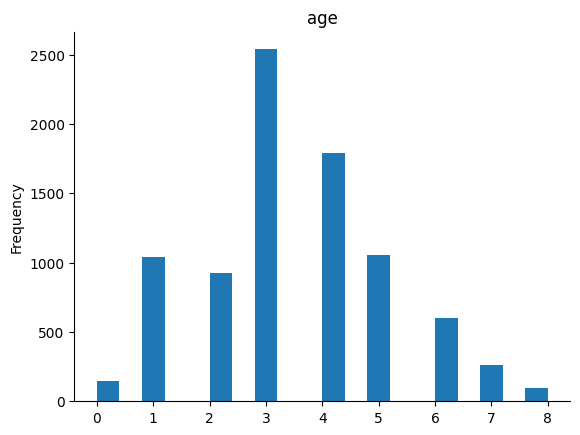

In [ ]:
# @title age

from matplotlib import pyplot as plt
balanced_df_val['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
! pip install --upgrade seldonian-engine

In [ ]:
type(balanced_df_train['image'])


pandas.core.series.Series

In [ ]:
# convert the images into array format

print(balanced_df_train['image'][1])

{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xe0\x00\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xc

In [ ]:
from PIL import Image
import io

# Example function to check image mode
def check_image_mode(image_dict):
    image_bytes = image_dict['bytes']
    image = Image.open(io.BytesIO(image_bytes))
    print(f"Image mode: {image.mode}")
    return image.mode

# Example usage with one image
image_mode = check_image_mode(balanced_df_train['image'][1])

Image mode: RGB


In [ ]:
import numpy as np
from PIL import Image
import io
from sklearn.preprocessing import OneHotEncoder
from seldonian.utils.io_utils import save_pickle

def process_rgb_image(image_dict):
    try:
        # Load image from bytes
        image_bytes = image_dict['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        # Resize to (48, 48)
        image = image.resize((48, 48))

        # Convert to NumPy array
        image_array = np.array(image, dtype=np.float32)

        # Normalize to [0, 1]
        image_array /= 255.0

        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Process the images
print("Processing RGB images...")
balanced_df_train['pixels'] = balanced_df_train['image'].apply(process_rgb_image)

# Drop rows where processing failed
balanced_df_train = balanced_df_train.dropna(subset=['pixels'])

# Convert processed images to a NumPy array
print("Converting images to NumPy array...")
images = np.array(balanced_df_train['pixels'].tolist())  # Shape: (num_samples, 48, 48, 3)

# Reshape to (num_samples, 3, 48, 48)
images = images.transpose(0, 3, 1, 2)

# Encode race and gender as one-hot vectors
onehot_encoder = OneHotEncoder()

print("Encoding race and gender...")
race_gender = balanced_df_train[['race', 'gender']].values
race_gender_encoded = onehot_encoder.fit_transform(race_gender).toarray()

# Combine features
print("Combining features...")
# Flatten images for tabular concatenation (if needed)
images_flat = images.reshape(images.shape[0], -1)
combined_features = np.hstack((images_flat, race_gender_encoded))  # Shape: (num_samples, flattened_image + race + gender)

# Extract labels (age)
labels = balanced_df_train['age'].values

# Save to pickle files
print("Saving features and labels...")
save_pickle('./features.pkl', combined_features)
save_pickle('./labels.pkl', labels)

print("Processing complete.")


Processing RGB images...
Converting images to NumPy array...
Encoding race and gender...
Combining features...
Saving features and labels...
Processing complete.
